<a href="https://colab.research.google.com/github/Ridham-suhagiya/Machine-learning/blob/master/COVID-19%20Radiography%20Database/Notebook/Covid_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/kaggle.json ~/.kaggle


In [5]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18366  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11041  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5622  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3916  
nickuzmenkov/nih-chest-xrays-tfrecords                      NIH Chest X-rays

In [6]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 733M/745M [00:04<00:00, 147MB/s]
100% 745M/745M [00:04<00:00, 160MB/s]


In [7]:
!chmod 600 /content/kaggle.json

In [ ]:
!unzip covid19-radiography-database.zip

Making directories and files for dividing the dataset into testing and training data 

In [9]:
#Importing all the necessary libraries
import cv2 as cv
import pandas as pd
from os import listdir
import pickle

In [10]:
from os import makedirs # Using os modul to execut the things more confortably.

#destination has the location of were the data is present
destination = '/content/COVID-19_Radiography_Dataset/'
#To segregate data into test and train subdirs is created
subdirs = ['Train_data/','Test_data/']
for subdir in subdirs:
#the types of data we have
  labeldirs = ['Covid/','Opacity/','Normal/','Pneumonia/']
  for label in labeldirs:
    #storing each type of data directory perticularly in train and test directories
    newdir = destination + subdir + label 
    makedirs(newdir)



In [11]:
from random import random
from shutil import copyfile
from random import seed
from os import listdir
#Seed(1) is used to have the same data everytime we run the code.
seed(1)
val = 0.25
label_train = []
label_test = []
#copying the training data images our train and test directories.
dir = 'Train_data/'
for folder in listdir(destination):
    if folder  in ['Normal','COVID','Lung_Opacity','Viral Pneumonia']:
        
        for file in listdir(destination + folder):
          if file.endswith('png'):
            src = destination + folder +'/' +file 
            value = random()
            # storing 25% of data into test directory.
            if value < val:
                dir = 'Test_data/'
                
            # Copying the data into the new directories created.
            if folder == 'COVID':
                des = destination + dir + 'Covid/' +file
                if dir =='Test_data/':
                  label_test.append(0)
                else:
                  label_train.append(0)
                copyfile(src,des)
            elif folder == 'Lung_Opacity':
                des = destination + dir + 'Opacity/' + file 
                if dir =='Test_data/':
                  label_test.append(1)
                else:
                  label_train.append(1)
                copyfile(src,des)
            elif folder =='Normal':
                des = destination + dir + 'Normal/' +file
                if dir =='Test_data/':
                  label_test.append(2)
                else:
                  label_train.append(2)
                copyfile(src,des)
            else:
                des = destination + dir + 'Pneumonia/' + file
                if dir =='Test_data/':
                  label_test.append(3)
                else:
                  label_train.append(3)
                copyfile(src,des)
            dir = 'Train_data/'


Generating the training and testing data

In [12]:
from keras.preprocessing.image import ImageDataGenerator
datogen =ImageDataGenerator(rescale = 1.0/255.0)    # data generator object creation
#Training data formed from the datogen object
train_it = datogen.flow_from_directory('/content/COVID-19_Radiography_Dataset/Train_data/',target_size = (299,299),class_mode = 'categorical',color_mode = 'rgb',batch_size = 64) 
#Testing data formed from the datogen object
test_it = datogen.flow_from_directory('/content/COVID-19_Radiography_Dataset/Test_data/',target_size = (299,299),class_mode = 'categorical',color_mode = 'rgb',batch_size = 64)

Found 15819 images belonging to 4 classes.
Found 5346 images belonging to 4 classes.


In [13]:
#The number of classes detected by the datagenerator object
train_it.class_indices

{'Covid': 0, 'Normal': 1, 'Opacity': 2, 'Pneumonia': 3}

In [14]:
!pip install tf

  Created wheel for tf: filename=tf-1.0.0-py3-none-any.whl size=1285 sha256=a06d47e68f42c600b34a734ae6f4faed7750b721e9e045278967f96c3498c7de
  Stored in directory: /root/.cache/pip/wheels/db/c7/58/cca67875b41ff853d3fdaa20b54a780ef2e045fbcacaef1ee3
Successfully built tf


In [15]:
#importing all the deep learning libraries
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [16]:
#Model 
def prepare_model():
  model = Sequential()
  model.add(Conv2D(32,(3,3),activation = 'relu',kernel_initializer = 'he_uniform',padding = 'same',input_shape = (299,299,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.6))
  model.add(Conv2D(64,(3,3),activation = 'relu',kernel_initializer = 'he_uniform',padding = 'same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.6))
  model.add(Conv2D(128,(3,3),activation = 'relu',kernel_initializer = 'he_uniform',padding = 'same'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.6))
  model.add(Flatten())
  model.add(Dense(256,activation = 'relu',kernel_initializer = 'he_uniform'))
  model.add(Dropout(0.4))
  model.add(Dense(4, activation = 'sigmoid'))
  opt = SGD(learning_rate = 0.004,momentum = 0.8)
  model.compile(optimizer = opt , loss = 'categorical_crossentropy',metrics = ['accuracy'])
  return model
early_stop = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience = 5 ,
                               restore_best_weights=True)
mc = ModelCheckpoint('cnn_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)




In [17]:
#Plot of the models performance 
import matplotlib.pyplot as plt
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()


In [33]:
# User defined function to manually check the performance of the model 
from keras.preprocessing import image 
import numpy as np
def model_tester(model):
  from random import randint
  dct = {1:'Covid',2:'Opacity',3:'Normal',4:'Pneumonia'}
  dct1 = {1:'COVID',2:'Lung_Opacity',3:'Normal', 4:'Viral Pneumonia'}
  
  for i in range(10):
    path = '/content/COVID-19_Radiography_Dataset/'
    virus = randint(1,4)
    imge = randint(1,1000)
    path = path   + dct1[virus]+ '/'+ dct1[virus] + '-' + str(imge) +'.png'
    img = image.load_img(path)
    img = image.img_to_array(img)
    img = np.array([img])
    img.shape

    print(dct[virus], " : ",model.predict(img))
    

In [19]:
# Saving the model using pickle modul
def save_model(model):
  import pickle
  loc = '/content/'
  model_1 = open('model_1','wb')
  pickle.dump(model,model_1)
  model_1.close()

In [20]:
datogen =ImageDataGenerator(rescale = 1.0/255.0)

As our model as unbalanced data we are trying to oversample the other categories to improve the performance of the model

In [21]:
# Oversampling Covid data 

from random import randint
num = randint(1,3000)
path = f'/content/COVID-19_Radiography_Dataset/COVID/COVID-{str(num)}.png'
img = image.load_img(path)
img = image.img_to_array(img)
img = np.array([img])
img.shape
dir ='/content/COVID-19_Radiography_Dataset/Train_data/Covid/'
prefix = 'COVID'
limit = 4800
i = 0
for batch in datogen.flow(img,batch_size = 1,save_to_dir = dir,save_prefix = prefix,save_format = 'png'):
  num = randint(1,3000)
  path = f'/content/COVID-19_Radiography_Dataset/COVID/COVID-{str(num)}.png'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = np.array([img])
  if i > limit:
    break
  i+=1

In [22]:
# Oversampling Lung Opacity data
num = randint(1,4000)
path = f'/content/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-{str(num)}.png'
img = image.load_img(path)
img = image.img_to_array(img)
img = np.array([img])
img.shape
dir ='/content/COVID-19_Radiography_Dataset/Train_data/Opacity/'
prefix = 'Lung_Opacity'
limit = 3000
i = 0
for batch in datogen.flow(img,batch_size = 1,save_to_dir = dir,save_prefix = prefix,save_format = 'png'):
  num = randint(1,1000)
  path = f'/content/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-{str(num)}.png'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = np.array([img])
  if i > limit:
    break
  i+=1

In [23]:
# Over sampling pneumonia
num = randint(1,1000)
path = f'/content/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-{str(num)}.png'
img = image.load_img(path)
img = image.img_to_array(img)
img = np.array([img])

dir ='/content/COVID-19_Radiography_Dataset/Train_data/Pneumonia/'
prefix = 'Viral Pneumonia'
limit = 6500
i = 0
for batch in datogen.flow(img,batch_size = 1,save_to_dir = dir,save_prefix = prefix,save_format = 'png'):
  num = randint(1,1000)
  path = f'/content/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-{str(num)}.png'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = np.array([img])
  
  if i > limit:
    break
  i+=1

In [24]:
#Model traning and testing 
model2 = prepare_model()  # model created
#Traning of model with 5 epochs and batch size of 64
training = model2.fit(train_it,validation_data= test_it,epochs = 5 ,verbose = 2 ,batch_size = 64,callbacks = [early_stop,mc])

epoches = len(training.history['loss'])
print('test_accuracy: ',model2.evaluate(test_it)) 
print('train_accuracy: ',model2.evaluate(train_it))

Epoch 1/5

Epoch 00001: val_loss improved from inf to 1.20642, saving model to cnn_model.h5
248/248 - 2886s - loss: 3.8141 - accuracy: 0.4732 - val_loss: 1.2064 - val_accuracy: 0.4744 - 2886s/epoch - 12s/step
Epoch 2/5

Epoch 00002: val_loss improved from 1.20642 to 1.19474, saving model to cnn_model.h5
248/248 - 2902s - loss: 1.1905 - accuracy: 0.4840 - val_loss: 1.1947 - val_accuracy: 0.4744 - 2902s/epoch - 12s/step
Epoch 3/5

Epoch 00003: val_loss improved from 1.19474 to 0.96582, saving model to cnn_model.h5
248/248 - 2936s - loss: 1.0733 - accuracy: 0.5254 - val_loss: 0.9658 - val_accuracy: 0.6077 - 2936s/epoch - 12s/step
Epoch 4/5

Epoch 00004: val_loss improved from 0.96582 to 0.81479, saving model to cnn_model.h5
248/248 - 2935s - loss: 0.8353 - accuracy: 0.6549 - val_loss: 0.8148 - val_accuracy: 0.6973 - 2935s/epoch - 12s/step
Epoch 5/5

Epoch 00005: val_loss improved from 0.81479 to 0.74726, saving model to cnn_model.h5
248/248 - 3032s - loss: 0.7328 - accuracy: 0.7048 - val_

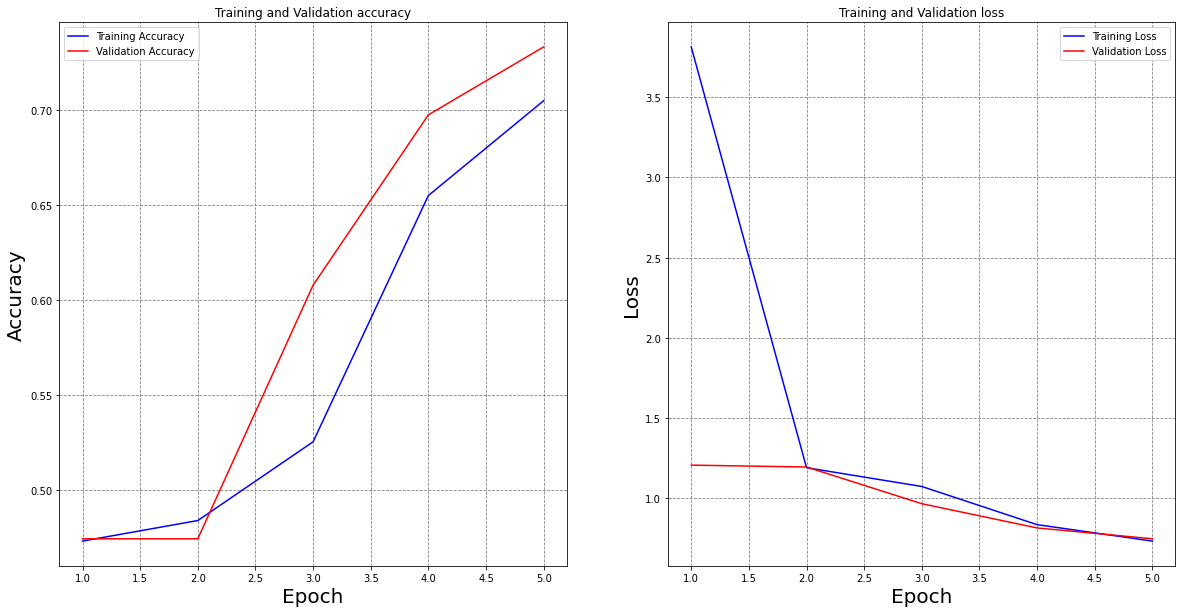

In [25]:
#the plot of model's performance
plotLearningCurve(training,epoches)

In [36]:
# Models predicting capabilities 
model_tester(model2)

Normal  :  [[0.         1.         0.11786309 1.        ]]
Normal  :  [[0.000000e+00 1.000000e+00 3.468353e-21 1.000000e+00]]
Normal  :  [[0.0000000e+00 1.0000000e+00 1.4985543e-34 1.0000000e+00]]
Normal  :  [[0. 1. 1. 1.]]
Normal  :  [[0.0000000e+00 1.0000000e+00 1.8300889e-26 1.0000000e+00]]
Pneumonia  :  [[0.        0.9770582 0.        1.       ]]
Covid  :  [[9.9677813e-01 3.3738968e-01 1.0000000e+00 3.3090962e-36]]
Opacity  :  [[1. 1. 1. 0.]]
Pneumonia  :  [[0.000000e+00 6.298179e-13 0.000000e+00 1.000000e+00]]
Normal  :  [[0.0000000e+00 1.0000000e+00 3.7708494e-24 1.0000000e+00]]


In [37]:
# Saving the model 
save_model(model2)

INFO:tensorflow:Assets written to: ram://581106e5-5a8a-411e-9333-9e8fad378072/assets


Although the models accuracy is 72 % still it is really difficult for the model to predict.
So the following things will be done to improve the model's performance:
As we can see from the above results, model is still not at its 

1.   As we can see from the above results, model is still not at its peak so to improve it I will be changing the dropout in the prepare_model function 
2.   I will also try different types of oversampling techniques to get rid of unbalanced data.

